# ECON 484 - Final Submission 2

#### <u>Name of Submission:</u> FireBreathingRubberDucky
#### <u>Accuracy of Algorithm in Question 1:</u>

* MSE = 0.08049
* R2 = 86.54%

#### <u>Accuracy of Algorithm in Question 2:</u>

* Percentage Accuracy = 92.83%


***

## Question 1  
**Goal:** Create an algorithm to predict the Log of Car Price.  
**Data:** Craigslist car listings data downloaded from Kaggle. Using "large" dataset provided, merged with "additional text" for each entry - 300,000 observations.  
**Testing Data:** 30,000 observations from the same source, additional text merged.

Procedure:
* Import Library,
* Import/Merge Data
* Log price value


### Import Libraries and Pre-process Data:

In [1]:
## Importing Libraries:
import pandas as pd
import statistics as stats
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import re
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

## Accuracy Tools:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score

## For Displaying:
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
import pydot
from IPython.display import Image

In [2]:
## Importing data:
large_data = pd.read_csv('final_predcomp_training_data_large.csv',low_memory=False)
## Since I plan to use dates extensively, ensuring parse_dates is mentioned:
text_data = pd.read_csv('final_predcomp_training_data_additional_text_variables.csv',low_memory=False,
                       parse_dates=["posting_date"])

#### FastAI Helper Functions:
Here I will define several functions taken from the FastAi library to make my processing easier. I would use their library but I cant get it running due to some update issues. Nevertheless, here is the sourcecode:

In [3]:
## Define add_datepart:
def add_datepart(df,fldname):
    '''
    Helper function that adds columns relevant to a date in the column fldname of df.
    '''
    fld = df[fldname]
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in ('Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
             'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end',
             'Is_year_start'):
        df[targ_pre+n] = getattr(fld.dt,n.lower())
    df[targ_pre+'Elapsed'] = (fld - fld.min()).dt.days
    df.drop(fldname, axis=1, inplace=True)
    
def train_cats(df):
    '''
    Change any columns of strings in a panda's dataframe to a column of categorical values. This applies the changes inplace.
    '''
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

## Apply_cats will be for the test_set later:
def apply_cats(df,trn):
    '''
    Changes any columns of strings in df into categorical variables using trn as a template for the category codes.
    '''
    for n,c in df.items():
        if trn[n].dtype.name=='category':
            df[n] = pd.Categorical(c, categories=trn[n].cat.categories, ordered=True)
            
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)
        
## --- For Proc_df ---

def fix_missing(df, col, name):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum(): df[name+'_na'] = pd.isnull(col)
        df[name] = col.fillna(col.median())

def numericalize(df, col, name, max_n_cat):
    if not is_numeric_dtype(col) and ( max_n_cat is None or col.nunique()>max_n_cat):
        df[name] = col.cat.codes+1
        
        
def proc_df(df, y_fld, skip_flds=None, do_scale=False,
           preproc_fn=None, max_n_cat=None, subset=None):
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    df = df.copy()
    if preproc_fn: preproc_fn(df)
    y = df[y_fld].values
    df.drop(skip_flds+[y_fld], axis=1, inplace=True)
    
    for n,c in df.items(): fix_missing(df,c,n)
    if do_scale: mapper = scale_vars(df)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    res = [pd.get_dummies(df, dummy_na=True), y]
    if not do_scale: return res
    return res + [mapper]

Merging datasources based on their ID column:

In [4]:
# Left Outer Merge:
q1data = large_data.merge(text_data, on='id', how='left')
q1data.head().T #Transposing for visibility

,0,1,2,3,4
id,7234568651,7229694925,7237581553,7235261085,7235871752
price,44989,39988,25990,18990,39995
year,2015,2017,2017,2011,2017
odometer,71639,108531,48931,97792,121365
cylinders,8,NaN,NaN,8,NaN
transmission,automatic,automatic,automatic,other,automatic
drive,4wd,NaN,NaN,NaN,4wd
type,truck,other,other,sedan,NaN
paint_color,NaN,silver,blue,NaN,white
size,NaN,NaN,NaN,NaN,NaN


The above displays the dataset we will be using, __transposed for visibility__ It has merged the additional text data based on the ID column, giving a total of 23 columns.
#### Dropping Unnecessary Columns:  
Since I'm not using the purely text data, or the Post ID, I will be dropping those columns:

In [5]:
## Dropping Columns I'm not going to use:
q1data.drop('model', axis=1, inplace=True)
q1data.drop('region', axis=1, inplace=True)
q1data.drop('description', axis=1, inplace=True)
q1data.drop('id', axis=1, inplace=True)

#### Addressing Categorical Variables:
Since there are text data for a lot of fields, I will be converting them to categories. RandomForestRegressor requires them to be numeric, so that's what I will do.

In [6]:
## Converting Price to Log Value of Price:
q1data['price']=np.log(q1data['price'])

## Creating new variables from date:
add_datepart(q1data, 'posting_date')

We converted the date into a number of related numeric variables that take into account time of year, time of month, day of week, etc.

Now converting all string data to categorical Data.

In [7]:
train_cats(q1data)

In [8]:
q1data.condition.cat.categories

Index(['excellent', 'fair', 'good', 'like new', 'new', 'salvage'], dtype='object')

In [9]:
## Ordering the condition variable, since its the only categorical variable that can be ordered.
q1data.condition.cat.set_categories(['new', 'like new', 'excellent', 'fair', 'good', 'salvage'], ordered=True, inplace=True)
q1data.condition.cat.categories

Index(['new', 'like new', 'excellent', 'fair', 'good', 'salvage'], dtype='object')

In [10]:
## Checking percentage of missing data in each column:
display_all(q1data.isnull().sum().sort_index()/len(q1data))

condition                   0.392477
cylinders                   0.363033
description_badcredit       0.000000
description_credit          0.000000
description_length          0.025997
description_owner           0.000000
drive                       0.283500
fuel                        0.006437
manufacturer                0.033483
odometer                    0.108480
paint_color                 0.286237
posting_Day                 0.012677
posting_Dayofweek           0.012677
posting_Dayofyear           0.012677
posting_Elapsed             0.012677
posting_Is_month_end        0.000000
posting_Is_month_start      0.000000
posting_Is_quarter_end      0.000000
posting_Is_quarter_start    0.000000
posting_Is_year_end         0.000000
posting_Is_year_start       0.000000
posting_Month               0.012677
posting_Week                0.012677
posting_Year                0.012677
price                       0.000000
size                        0.700913
state                       0.012623
t

### Processing Dataframe:

1. Split the data into Training and Validation Data. 
2. We must replace categories with their numeric codes.
3. Handle missing data:  
    * Categorical: NA will be 0, other categories will be 1,2,etc. (Currently categoricals are -1 for NA)
    * Continuous: NA will be median of the column. Another column will be created named "ColumnName_na", which will be boolean, 1 if NA, 0 if not.
4. Split the dependent variable into a seperate variable.

Other than the first step, the function proc_df does all these things:

In [11]:
## Split Data into Training and Validation:
q1_train, q1_valid = train_test_split(q1data, test_size=0.2)

## Doing remaining processing:
q1_train_x, q1_train_y = proc_df(q1_train, 'price')
q1_valid_x, q1_valid_y = proc_df(q1_valid, 'price')

In [12]:
q1_train_x.T

,145571,25964,146496,116019,103384,284020,230978,101160,175387,50508,...,190244,256792,156337,168911,4068,282974,179690,264077,173965,77610
year,2010,2016,2014,2013,2014,2008,2018,2018,2015,2015,...,2001,2004,2016,2011,2015,2017,2006,2011,2002,2009
odometer,90000,52438,114000,70110,11707,108938,18644,117212,106957,36639,...,78844,276000,90000,127722,3580,90000,90000,97000,150000,228525
cylinders,4,6,6,8,6,4,4,6,4,6,...,6,4,6,4,8,4,6,6,6,8
transmission,1,1,1,1,3,1,1,1,1,3,...,1,1,1,1,3,1,1,1,1,1
drive,2,0,0,1,3,2,1,0,2,2,...,2,2,0,2,3,2,0,3,3,1
type,0,0,13,9,8,10,1,8,10,5,...,13,10,11,12,4,10,0,10,10,11
paint_color,11,0,1,0,0,8,6,11,4,11,...,1,6,11,11,1,10,10,2,11,2
size,0,0,0,0,0,2,3,0,3,0,...,3,3,0,4,0,2,0,1,3,0
title_status,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,5,1,1,1,1
condition,5,0,3,5,5,5,0,0,0,5,...,5,5,5,5,5,2,0,3,4,0


As we can see, all the data is now numeric! Its ready for Training:

### Tuning Model:
#### Basic, Untuned Forest:

In [13]:
n = RandomForestRegressor(n_estimators=40, n_jobs=-1)
n.fit(q1_train_x,q1_train_y)
res = mse(q1_train_y, n.predict(q1_train_x)), mse(q1_valid_y, n.predict(q1_valid_x)), n.score(q1_train_x,q1_train_y), n.score(q1_valid_x,q1_valid_y)
print("MSE - Train, MSE - Valid, R2 - Train, R2 - Valid:")
print(res)

MSE - Train, MSE - Valid, R2 - Train, R2 - Valid:
(0.012085009182457149, 0.07994308392379729, 0.9797189734567184, 0.8653475639210448)


#### 1. Number of Trees:  
Visualizing the effect of adding more trees, so we know if adding trees is helping, if we need to add more trees, etc:

In [14]:
preds = np.stack([t.predict(q1_valid_x) for t in n.estimators_])
preds.shape

(40, 60000)

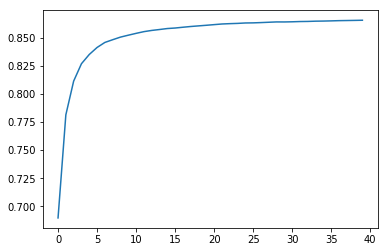

In [15]:
plt.plot([r2_score(q1_valid_y, np.mean(preds[:i+1], axis=0)) for i in range(40)]);

While there are improvements, there are definitely diminishing returns. Perhaps once other tuning parameters are determined, I will run with a large number of trees and leave it overnight.  

#### 2. Minimum Samples Leaves:
Checking the effects of min_samples_leaf on resulting R2. For easier computing, using only 10 trees.

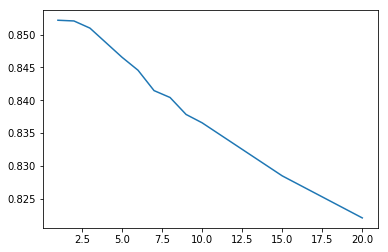

In [16]:
leaves = [1,2,3,4,5,6,7,8,9,10,15,20]
score = [0,0,0,0,0,0,0,0,0,0,0,0]

temp_score = [0,0,0,0,0]

for i in range(12):
    for j in range(5):
        n = RandomForestRegressor(n_estimators=10, min_samples_leaf=leaves[i], n_jobs=-1)
        n.fit(q1_train_x,q1_train_y)
        temp_score[j] = n.score(q1_valid_x,q1_valid_y)
    score[i] = np.mean(temp_score)

plt.plot(leaves,score)

As we can see above, the best score is at **min_samples_leaf = 1**, after which the R2 declines steeply.

#### 3. Max Features:
With this feature, we can get it to choose from a different set of columns with every split. Let's see if it has any effect on validation R2.

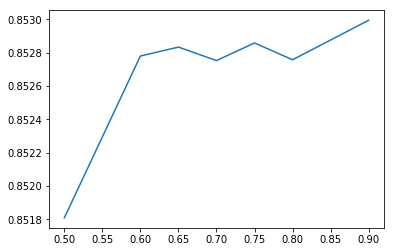

In [17]:
feats = [0.9, 0.8, 0.75, 0.7, 0.65, 0.6, 0.5]
score = [0,0,0,0,0,0,0]
temp_score = [0,0,0,0,0]

for i in range(7):
    for j in range(5):
        n = RandomForestRegressor(n_estimators=10, min_samples_leaf=1, max_features=feats[i], n_jobs=-1)
        n.fit(q1_train_x,q1_train_y)
        temp_score[j] = n.score(q1_valid_x,q1_valid_y)
    score[i] = np.mean(temp_score)

plt.plot(feats,score)

I have done this many times and every time I get a different answer. I believe its because of a different type of subset of the data resulting in a completely different result. So I have created an averaging system, where each iteration is tried five times. Its still a strange graph, but the final best result is **max_features=0.8**.

In [21]:
n = RandomForestRegressor(n_estimators=40, min_samples_leaf=1, max_features=0.8, n_jobs=-1)
n.fit(q1_train_x,q1_train_y)
res = mse(q1_train_y, n.predict(q1_train_x)), mse(q1_valid_y, n.predict(q1_valid_x)), n.score(q1_train_x,q1_train_y), n.score(q1_valid_x,q1_valid_y)
print("MSE - Train, MSE - Valid, R2 - Train, R2 - Valid:")
print(res)

MSE - Train, MSE - Valid, R2 - Train, R2 - Valid:
(0.011959116558077368, 0.07924596600895752, 0.9799302460853199, 0.866521757120258)


So we have now been able to produce a well tuned model with a high R2:

### Final Model:
Since we know more trees will give us a better result, I will be using 500 trees for this last model.

In [22]:
n = RandomForestRegressor(n_estimators=500, min_samples_leaf=1, max_features=0.8, n_jobs=-1)
n.fit(q1_train_x,q1_train_y)
res = mse(q1_train_y, n.predict(q1_train_x)), mse(q1_valid_y, n.predict(q1_valid_x)), n.score(q1_train_x,q1_train_y), n.score(q1_valid_x,q1_valid_y)
print("MSE - Train, MSE - Valid, R2 - Train, R2 - Valid:")
print(res)

MSE - Train, MSE - Valid, R2 - Train, R2 - Valid:
(0.010627783543934113, 0.07682648767173257, 0.9821644851984337, 0.8705970146179315)


Here are the **final results**:
* MSE = 0.07738
* R2 = 87.36%

### Feature Importance:
I will use a rather crude method to determine feature importance. I will redo this regression, but a single tree with a max depth of 3, so it is a managable tree to display. Looking at this tree should show us the features that were most important to our prediction.

In [34]:
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3, bootstrap=False, n_jobs=-1)
rf_small.fit(q1_train_x,q1_train_y)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Creating list of features
feature_list = list(q1_train_x.columns)

# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)

(graph, ) = pydot.graph_from_dot_file('small_tree.dot')

graph.write_png('small_tree.png');

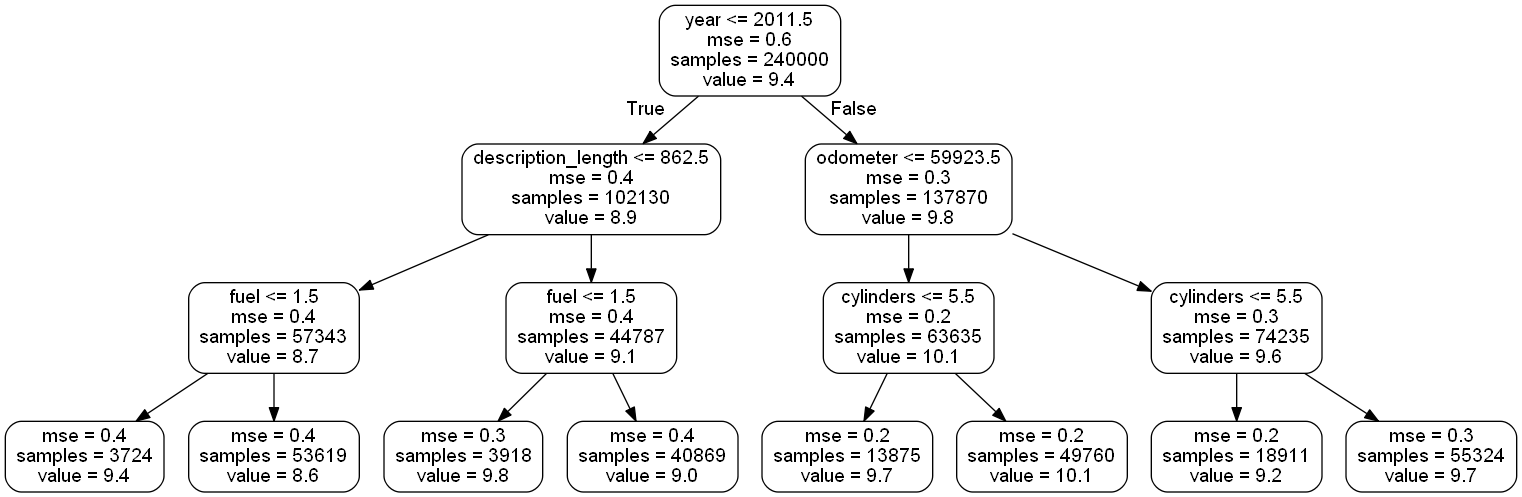

In [35]:
# Displaying this exported image:
Image('small_tree.png')

As we see here, the single most important variable is the year the car is from. After that, if it is newer than 2011, its odometer reading matters most, versus if its older, its description legnth matters the most. If its newer than 2011, after mileage, its number of cylinders matters most, versus otherwise, its fuel type matters most.

### Test Accuracy:
Processing the Test Data in the same way as Training Data:

In [23]:
## Importing data:
large_test = pd.read_csv('final_predcomp_test_data.csv',low_memory=False)
## Since I plan to use dates extensively, ensuring parse_dates is mentioned:
text_test = pd.read_csv('final_predcomp_test_data_additional_text_variables.csv',low_memory=False,
                       parse_dates=["posting_date"])
# Left Outer Merge:
testdata = large_test.merge(text_test, on='id', how='left')

## Dropping Columns I'm not going to use:
testdata.drop('model', axis=1, inplace=True)
testdata.drop('region', axis=1, inplace=True)
testdata.drop('description', axis=1, inplace=True)
testdata.drop('id', axis=1, inplace=True)

## Converting Price to Log Value of Price:
testdata['price']=np.log(testdata['price'])

## Creating new variables from date:
add_datepart(testdata, 'posting_date')

Now we use the apply_cats function to apply the same categories as our q1data to our testdata. Without this the results will mean nothing.

In [24]:
## Ensuring same categories:
apply_cats(testdata, q1data)

## Applying final processing using proc_df:
q1test_x, q1test_y = proc_df(testdata, 'price')

Predicting Results of our model on test data:

In [25]:
res = mse(q1test_y, n.predict(q1test_x)), n.score(q1test_x,q1test_y)
print("MSE - Test, R2 - Test:")
print(res)

MSE - Test, R2 - Test:
(0.08049028489142286, 0.8653861479283214)


### Test Results:
* MSE - 0.08049
* R2 - 86.54%

## Question 2  
**Goal:** Create an algorithm that predicts whether car price is less than $10,000.  
**Data:** Craigslist car listings data downloaded from Kaggle. Using "large" dataset provided, merged with "additional text" for each entry - 300,000 observations.  
**Testing Data:** 30,000 observations from the same source, additional text merged.  

### Processing Data:
Doing the same processes as Q1, with the exception of handling Price. Price will be made into a binary variable.

In [6]:
## Merging datasources based on their ID column:
# Left Outer Merge:
q2data = large_data.merge(text_data, on='id', how='left')

## Dropping Columns I'm not going to use:
q2data.drop('model', axis=1, inplace=True)
q2data.drop('region', axis=1, inplace=True)
q2data.drop('description', axis=1, inplace=True)
q2data.drop('id', axis=1, inplace=True)

## Converting Price to Binary Variable for Price >$10,000:
q2data['price'].values[q2data['price'] < 10000] = 0
q2data['price'].values[q2data['price'] >= 10000] = 1
q2data['price'] = q2data['price'].astype(bool)

## Creating new variables from date:
add_datepart(q2data, 'posting_date')

In [7]:
train_cats(q2data)

## Ordering the condition variable, since its the only categorical variable that can be ordered.
q2data.condition.cat.set_categories(['new', 'like new', 'excellent', 'fair', 'good', 'salvage'], ordered=True, inplace=True)
q2data.condition.cat.categories

Index(['new', 'like new', 'excellent', 'fair', 'good', 'salvage'], dtype='object')

Remaining Steps:
1. Split the data into Training and Validation Data. 
2. We must replace categories with their numeric codes.
3. Handle missing data:  
    * Categorical: NA will be 0, other categories will be 1,2,etc. (Currently categoricals are -1 for NA)
    * Continuous: NA will be median of the column. Another column will be created named "ColumnName_na", which will be boolean, 1 if NA, 0 if not.
4. Split the dependent variable into a seperate variable.

Other than the first step, the function proc_df does all these things:

In [8]:
## Split Data into Training and Validation:
q2_train, q2_valid = train_test_split(q2data, test_size=0.2)

## Doing remaining processing:
q2_train_x, q2_train_y = proc_df(q2_train, 'price')
q2_valid_x, q2_valid_y = proc_df(q2_valid, 'price')

In [9]:
## List of the columns in the data:
q2_train_x.columns

Index(['year', 'odometer', 'cylinders', 'transmission', 'drive', 'type',
       'paint_color', 'size', 'title_status', 'condition', 'fuel', 'state',
       'manufacturer', 'description_length', 'description_credit',
       'description_owner', 'description_badcredit', 'posting_Year',
       'posting_Month', 'posting_Week', 'posting_Day', 'posting_Dayofweek',
       'posting_Dayofyear', 'posting_Is_month_end', 'posting_Is_month_start',
       'posting_Is_quarter_end', 'posting_Is_quarter_start',
       'posting_Is_year_end', 'posting_Is_year_start', 'posting_Elapsed',
       'year_na', 'odometer_na', 'cylinders_na', 'description_length_na',
       'posting_Year_na', 'posting_Month_na', 'posting_Week_na',
       'posting_Day_na', 'posting_Dayofweek_na', 'posting_Dayofyear_na',
       'posting_Elapsed_na'],
      dtype='object')

### Tuning Model:

#### Untuned Regression Forest Classifier:


In [10]:
m = RandomForestClassifier(n_estimators=40, n_jobs=-1)
m.fit(q2_train_x,q2_train_y)
res = accuracy_score(q2_train_y, m.predict(q2_train_x)), accuracy_score(q2_valid_y, m.predict(q2_valid_x))
print("Percent Accuracy - Train, Percent Accuracy - Valid:")
print(res)

Percent Accuracy - Train, Percent Accuracy - Valid:
(0.999825, 0.9177833333333333)


#### 1. Determining Number of Trees:

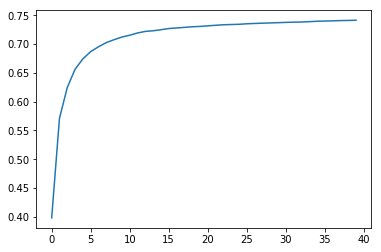

In [11]:
preds = np.stack([t.predict(q2_valid_x) for t in m.estimators_])
plt.plot([r2_score(q2_valid_y, np.mean(preds[:i+1], axis=0)) for i in range(40)]);

As expected, increasing number of trees increases accuracy. Lets move on to Minimum Sample Leaves:

#### 2. Minimum Samples Leaves:
Checking the effects of min_samples_leaf on resulting Percentage Accuracy. For easier computing, using only 10 trees.

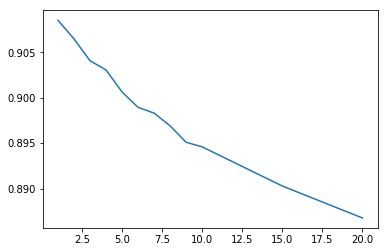

In [12]:
leaves = [1,2,3,4,5,6,7,8,9,10,15,20]
score = [0,0,0,0,0,0,0,0,0,0,0,0]

temp_score = [0,0,0,0,0]

for i in range(12):
    for j in range(5):
        m = RandomForestClassifier(n_estimators=10, min_samples_leaf=leaves[i], n_jobs=-1)
        m.fit(q2_train_x,q2_train_y)
        temp_score[j] = accuracy_score(q2_valid_y, m.predict(q2_valid_x))
    score[i] = np.mean(temp_score)

plt.plot(leaves,score)

Similar result as before.

#### 3. Max Features:

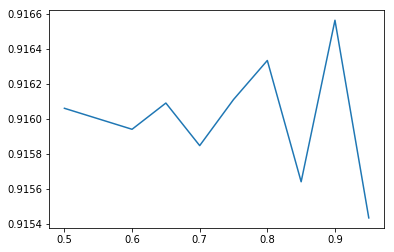

In [13]:
feats = [0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
score = [0,0,0,0,0,0,0,0,0]
temp_score = [0,0,0,0,0]

for i in range(9):
    for j in range(5):
        m = RandomForestClassifier(n_estimators=10, min_samples_leaf=1, max_features=feats[i], n_jobs=-1)
        m.fit(q2_train_x,q2_train_y)
        temp_score[j] = accuracy_score(q2_valid_y, m.predict(q2_valid_x))
    score[i] = np.mean(temp_score)

plt.plot(feats,score)

Again this gives a strange graph, that is different every time. There is always a peak at 0.7 or 0.9 though, so I will use **max_features=0.7** since its highest on this graph

In [14]:
m = RandomForestClassifier(n_estimators=40,  min_samples_leaf=1, max_features=0.7, n_jobs=-1)
m.fit(q2_train_x,q2_train_y)
res = accuracy_score(q2_train_y, m.predict(q2_train_x)), accuracy_score(q2_valid_y, m.predict(q2_valid_x))
print("Percent Accuracy - Train, Percent Accuracy - Valid:")
print(res)

Percent Accuracy - Train, Percent Accuracy - Valid:
(0.9996333333333334, 0.9248)


### Final Model:
Now that we have tuned our model, I will run the final model with a high number of trees:

In [15]:
m = RandomForestClassifier(n_estimators=500,  min_samples_leaf=1, max_features=0.7, n_jobs=-1)
m.fit(q2_train_x,q2_train_y)
res = accuracy_score(q2_train_y, m.predict(q2_train_x)), accuracy_score(q2_valid_y, m.predict(q2_valid_x))
print("Percent Accuracy - Train, Percent Accuracy - Valid:")
print(res)

Percent Accuracy - Train, Percent Accuracy - Valid:
(0.999975, 0.9262)


Here are the **final results**:
* Percentage Accuracy = 92.81%

### Feature Importance:
As in Q1, I will redo this regression, but a single tree with a max depth of 3, so it is a managable tree to display. Looking at this tree should show us the features that were most important to our prediction.

In [77]:
# Limit depth of tree to 3 levels
rf_small = RandomForestClassifier(n_estimators=10, max_depth = 3, bootstrap=False, n_jobs=-1)
rf_small.fit(q2_train_x,q2_train_y)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Creating list of features
feature_list = list(q2_train_x.columns)

# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree2.dot', feature_names = feature_list, rounded = True, precision = 1)

(graph, ) = pydot.graph_from_dot_file('small_tree2.dot')

graph.write_png('small_tree2.png');

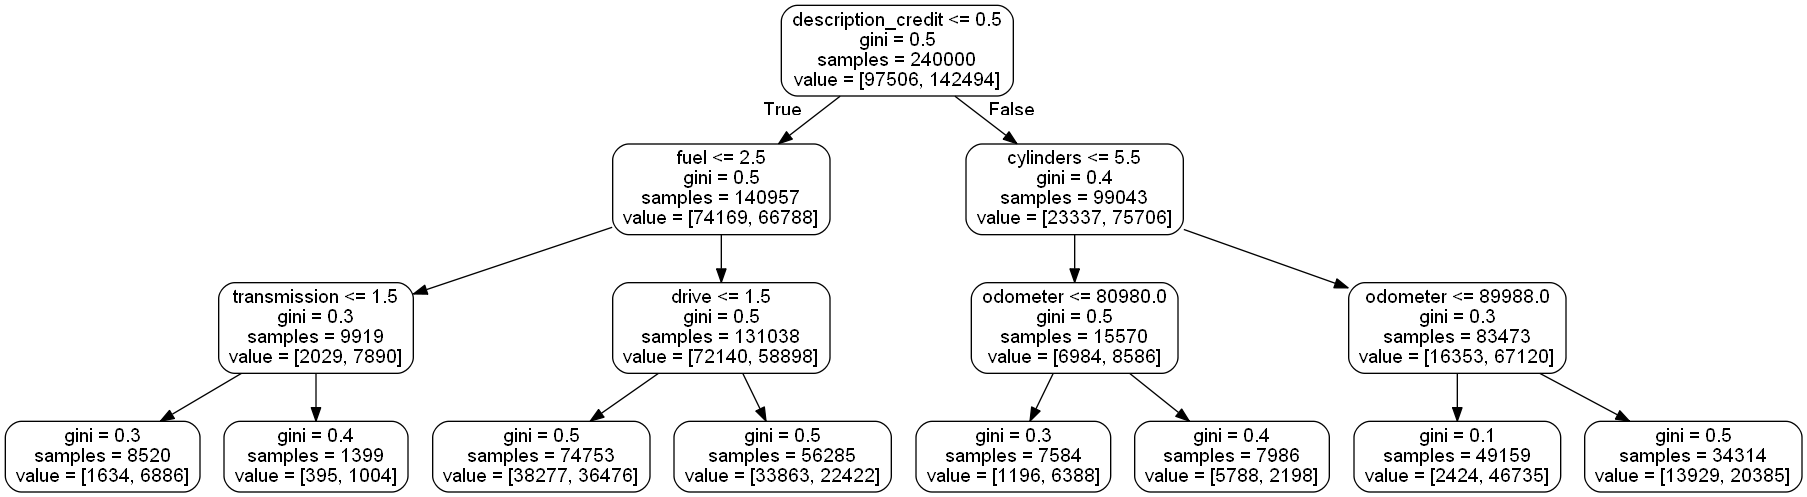

In [79]:
# Displaying this exported image:
Image('small_tree2.png')

The Results show that whether the Description mentions Credit is the strongest indicator of whether the car will be less than $10k. If Credit is mentioned, its more likely to be >10k. Then, the other variables are as shown.

## Test Accuracy:
Processing the Test Data in the same way as Training Data:

In [16]:
## Importing data:
large_test2 = pd.read_csv('final_predcomp_test_data.csv',low_memory=False)
## Since I plan to use dates extensively, ensuring parse_dates is mentioned:
text_test2 = pd.read_csv('final_predcomp_test_data_additional_text_variables.csv',low_memory=False,
                       parse_dates=["posting_date"])
# Left Outer Merge:
testdata2 = large_test2.merge(text_test2, on='id', how='left')

## Dropping Columns I'm not going to use:
testdata2.drop('model', axis=1, inplace=True)
testdata2.drop('region', axis=1, inplace=True)
testdata2.drop('description', axis=1, inplace=True)
testdata2.drop('id', axis=1, inplace=True)

## Converting Price to Binary Variable for Price >$10,000:
testdata2['price'].values[testdata2['price'] < 10000] = 0
testdata2['price'].values[testdata2['price'] >= 10000] = 1
testdata2['price'] = testdata2['price'].astype(bool)

## Creating new variables from date:
add_datepart(testdata2, 'posting_date')

Predicting Results of our model on test data:

In [17]:
## Ensuring same categories:
apply_cats(testdata2, q2data)

## Applying final processing using proc_df:
q2test_x, q2test_y = proc_df(testdata2, 'price')

Predicting Results of our model on test data:

In [20]:
res = accuracy_score(q2test_y, m.predict(q2test_x))
print("Percent Accuracy - Test")
print(res)


Percent Accuracy - Test
0.9283


## Bonus Question
I will try to replicate the results of the paper with my own data. In the interest of time, I'll be confirming whether the results visually look similar, aka is there a discontinuity at every 10k miles. This should be good enough to show us if the trend continues.

In [113]:
## Creating New Dataframe:
bonusdata = large_data[['price','odometer']].copy()

## Dropping NaN values:
bonusdata = bonusdata.dropna()

#### Rounding Odometer down to nearest 500:
Doing this so its the same as our reference article.

In [114]:
## Defining Function to round down to the nearest $500:
def custom_round(x, base=500):
    return int(base * np.floor(float(x)/base))

bonusdata.odometer = bonusdata.odometer.apply(lambda x: custom_round(x, base=500))

Do we need to do an Average Sale Price? Or can we just plot the price as is.

Text(0, 0.5, 'Sales price')

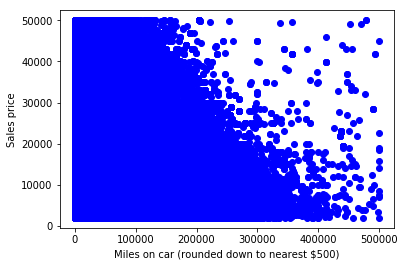

In [117]:
plt.scatter(bonusdata.odometer,bonusdata.price,c='blue')
plt.xlabel("Miles on car (rounded down to nearest $500)")
plt.ylabel("Sale price")

Whoops. This is not useful at all. We're going to need the average sale price.

In [123]:
bonusdata1 = bonusdata.groupby('odometer').mean()

Text(0, 0.5, 'Average Sale price')

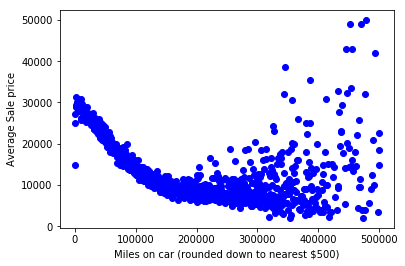

In [127]:
plt.scatter(bonusdata1.index,bonusdata1.price,c='blue')
plt.xlabel("Miles on car (rounded down to nearest $500)")
plt.ylabel("Average Sale price")

The problem here is that I did not truncate the data. The **cars at the extremes are bound to have weird pricing**, primarily due to fewer datapoints. They may also have qualitative factors such as rarity, etc. Truncating data to 120000 as done in the article:

In [138]:
bonusdata1 = bonusdata1.truncate(after=120000)

Text(0, 0.5, 'Average Sale price')

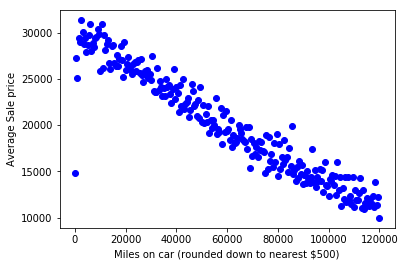

In [139]:
plt.scatter(bonusdata1.index,bonusdata1.price,c='blue')
plt.xlabel("Miles on car (rounded down to nearest $500)")
plt.ylabel("Average Sale price")

The spread here is too high for us to be able to meaningfully say anything about its adherence to the article's findings. Going to try and smoothen out more by rounding to nearest 1000 miles:

Text(0, 0.5, 'Average Sale price')

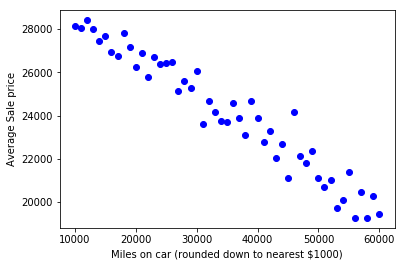

In [163]:
## Creating New Dataframe:
bonusdata = large_data[['price','odometer']].copy()

## Dropping NaN values:
bonusdata = bonusdata.dropna()

def custom_round(x, base=1000):
    return int(base * np.floor(float(x)/base))

bonusdata.odometer = bonusdata.odometer.apply(lambda x: custom_round(x, base=1000))

bonusdata1 = bonusdata.groupby('odometer').mean()
bonusdata1 = bonusdata1.truncate(after=60000)
bonusdata1 = bonusdata1.truncate(before=10000)

plt.scatter(bonusdata1.index,bonusdata1.price,c='blue')
plt.xlabel("Miles on car (rounded down to nearest $1000)")
plt.ylabel("Average Sale price")

Again, while the data is following the general downwards trend, its **too noisy to see any discontinuities on the graph**. There is a **vague discontinuity at odometer = 30,000**, but nothing other than that.

My theory is that I dont have enough data to form a clean line like the writer of the article.

In [167]:
bonusdata1.price.iloc[0:11]

odometer
10000    28153.094304
11000    28056.616512
12000    28408.691143
13000    28002.321217
14000    27430.047918
15000    27671.644460
16000    26946.926539
17000    26755.863190
18000    27803.702407
19000    27152.126492
20000    26257.227864
Name: price, dtype: float64

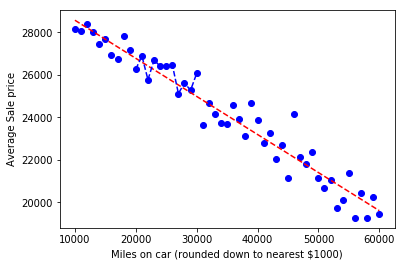

In [170]:
## Creating New Dataframe:
bonusdata = large_data[['price','odometer']].copy()

## Dropping NaN values:
bonusdata = bonusdata.dropna()

def custom_round(x, base=1000):
    return int(base * np.floor(float(x)/base))

bonusdata.odometer = bonusdata.odometer.apply(lambda x: custom_round(x, base=1000))

bonusdata1 = bonusdata.groupby('odometer').mean()
bonusdata1 = bonusdata1.truncate(after=60000)
bonusdata1 = bonusdata1.truncate(before=10000)

plt.scatter(bonusdata1.index,bonusdata1.price,c='blue')
plt.xlabel("Miles on car (rounded down to nearest $1000)")
plt.ylabel("Average Sale price")

## Main Trendline:
z = np.polyfit(bonusdata1.index, bonusdata1.price, 1)
p = np.poly1d(z)
plt.plot(bonusdata1.index,p(bonusdata1.index),"r--")
## Segment Trendlines:

z = np.polyfit(bonusdata1.index[10:21], bonusdata1.price.iloc[10:21], 1)
p = np.poly1d(z)
plt.plot(bonusdata1.index[10:21], bonusdata1.price.iloc[10:21],"b--")